# True Reach Estimator- Estimating for the 25k through 65k bin

***

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

# Group 4 - Followers = 25K-65K

After many trials we have settled on a 3 variable regression model that uses comments, likes and followers to predict our final reach estimate. 

In order to fit the model most accurately to a normal situation we had to remove special outliers. Instagram's algorithm produces larger variance in individual results. These results had a detrimental effect on any prediction results. Eliminating outliers of a single large or small variable has a negative effect on our model as our users vary greatly. However, we determined that issues arose when the ratio of certain variables violated normality. As such, we chose to eliminate the upper and lower 10% of the offending ratios to help fit the model.

For this group we have only included users with followers from 5,000 to 12,500 to better match the reactions to posts. 

Process:

- work with users that have  25k-65k followers.
- Change the confidence interval to 10% or 90%.

- Import the data
- Split the data into a test and training set
- Set conditions on the training data to eliminate outliers
- Create a regression model on our variables to determine the effectiveness of the data so far 
- Use the regression model to check for accuracy in the perdiction across the dataset
- Summarize our findings and suggest next steps if unsucessful

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
plt.style.use('seaborn')
%matplotlib inline

Pull in the CSV file

In [2]:
df = pd.read_csv('trial_1_2.csv')

First, look at the data

In [3]:
df.head()

,Unnamed: 0,followers,published,likes,comments,impressions,reach
0,0,68172,2018-06-18T01:26:44.000+00:00,107,1,2301,1782
1,1,68172,2018-06-17T18:47:24.000+00:00,323,1,9563,8131
2,2,68223,2018-06-19T02:24:03.000+00:00,38,1,290,261
3,3,68223,2018-06-18T16:44:25.000+00:00,656,12,11360,9082
4,4,67812,2018-05-30T03:22:11.000+00:00,2044,26,100970,85215


Drop columns that are unneeded.

In [4]:
df.drop(['Unnamed: 0', 'published', 'impressions'], axis=1, inplace=True)

**First Data Clean**

Anyone with very little reach will skew the data. It's probably a bot. Lets remove all rows where the reach is less than 1.

In [5]:
df = df.loc[(df['reach']>=1)] #& (df2['reach']<200000)
len(df)

727933

### Set bin for follower count
Next we remove rows that have less than 25000 and more than 65000 followers so that we can isolate our bin for our trial.

In [6]:
df = df.loc[(df['followers']>25000) & (df['followers']<65000)]
len(df)

117231

Setting comments to greater than zero to avoid zero division errors

In [7]:
df = df.loc[(df['comments']>=1)] # & (df2['comments']<=2000)
len(df)

115528

Remove rows with less than 1 like to eliminate outliers.

In [8]:
df = df.loc[(df['likes']>=1)]
len(df)

115528

Remove wierd situations where there are more comments or likes than reach.

In [9]:
df = df.loc[(df.likes<df.reach)]
df = df.loc[(df.comments<df.reach)]
len(df)

113197

## Split the data sets into two - a test and a training data set: 

In [10]:
from sklearn.model_selection import train_test_split
df2, test = train_test_split(df, test_size=0.2)

In [11]:
len(df2)

90557

---

# Eliminate the data with *RATIOS* outside of the norm. 

## Step 1 - Add ratio colums onto the data frame

In [12]:
df2['reach_/_followers'] = df2['reach']/df2['followers']

In [13]:
df2['reach_/_likes'] = df2['reach']/df2['likes']

In [14]:
df2['reach_/_comments'] = df2['reach']/df2['comments']

#### Look at the distribution of those ratio without manipulation

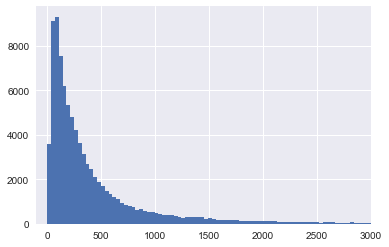

In [15]:
plt.hist(df2['reach_/_comments'], bins=1000)
plt.xlim(-100,3000);

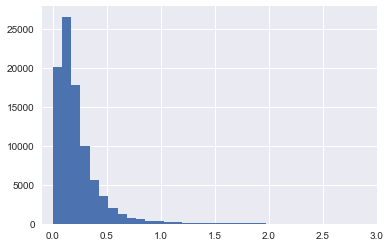

In [16]:
plt.hist(df2['reach_/_followers'], bins=1000)
plt.xlim(-.1,3);

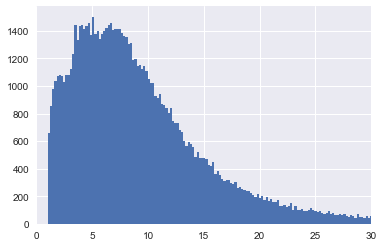

In [17]:
plt.hist(df2['reach_/_likes'], bins=1000)
plt.xlim(-.003, 30);

## Step 2 - Set confidence intervals for each ration

 *Just checking what some filters would look like without finding a confidence interval.* 

In [18]:
df2= df2.loc[(df2['reach_/_followers'] > df2['reach_/_followers'].quantile(.1))]
df2= df2.loc[(df2['reach_/_likes'] > df2['reach_/_likes'].quantile(.1))]
df2= df2.loc[(df2['reach_/_comments'] > df2['reach_/_comments'].quantile(.1))]

df2= df2.loc[(df2['reach_/_followers'] < df2['reach_/_followers'].quantile(.9))]
df2= df2.loc[(df2['reach_/_likes'] < df2['reach_/_likes'].quantile(.9))]
df2= df2.loc[(df2['reach_/_comments'] < df2['reach_/_comments'].quantile(.9))]

In [19]:
df2.head()

,followers,likes,comments,reach,reach_/_followers,reach_/_likes,reach_/_comments
12956,38300,419,10,5892,0.153838,14.062053,589.200000
529011,51975,669,10,7810,0.150265,11.674141,781.000000
101639,53597,645,20,3666,0.068399,5.683721,183.300000
326112,47009,708,17,3482,0.074071,4.918079,204.823529
276457,33698,1625,17,14518,0.430827,8.934154,854.000000


In [20]:
len(df2)

48123

Now, what does our data look like? 

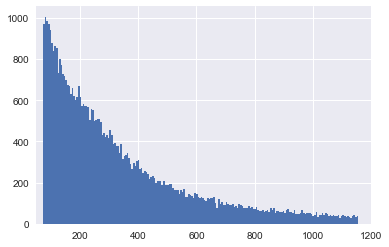

In [21]:
plt.hist(df2['reach_/_comments'], bins=200)
plt.xlim(50, 1200);

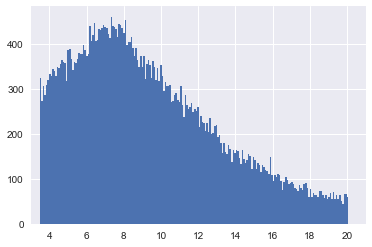

In [22]:
plt.hist(df2['reach_/_likes'], bins=200)
plt.xlim(3,21);

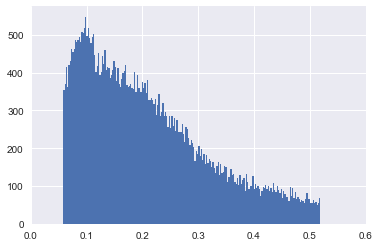

In [23]:
plt.hist(df2['reach_/_followers'], bins=200)
plt.xlim(0,.6);

# Fit the model

In [24]:
lr_model = ols(formula='reach~followers + likes + comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                 2.381e+04
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:49:30   Log-Likelihood:            -4.5795e+05
No. Observations:               48123   AIC:                         9.159e+05
Df Residuals:                   48119   BIC:                         9.159e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -417.3158     55.993     -7.453      0.000    -527.063    -307.569
followers      0.0805      0.001     58.637      0.000       0.078       0.083
likes          4.7493      0.027    178.189      0.000       4.697       4.802
comments      21.5024      0.558     38.551      0.000      20.409      22.596
==============================================================================
Omnibus:                     5735.352   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11333.617
Skew:                           0.765   Prob(JB):                         0.00
Kurtosis:                       4.820   Cond. No.                     1.59e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Scatterplots 
- Next we look at scatter plots of our data to further look for outliers and the correlation of our independent variable to our dependent variable. 

Text(0.5, 1.0, 'Followers Scatter plot')

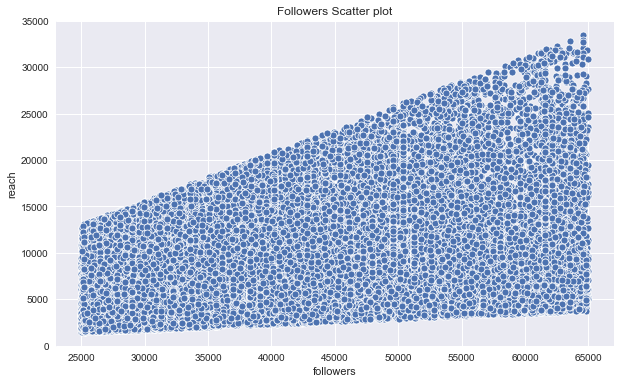

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Scatter plot")

Text(0.5, 1.0, 'Likes Scatter plot')

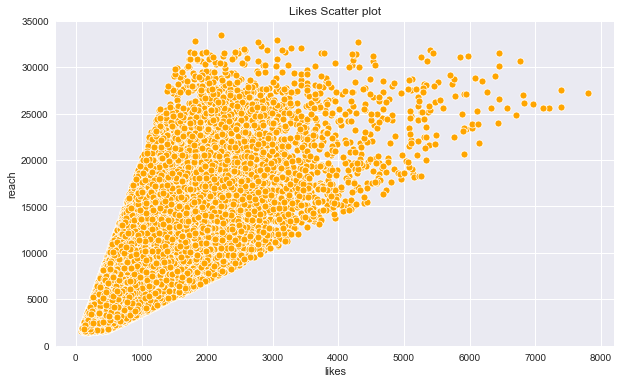

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes, color='orange' )
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Scatter plot")

Text(0.5, 1.0, 'Comments Scatter plot')

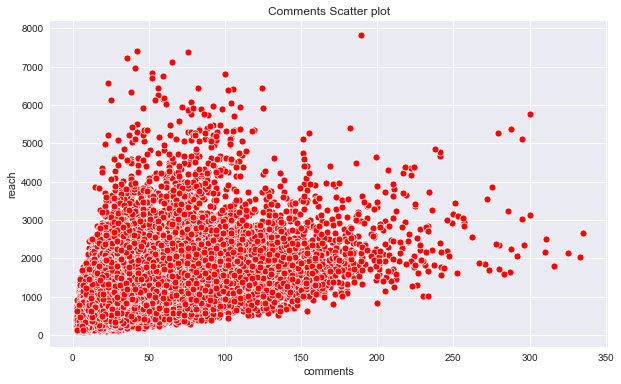

In [27]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.likes, x=df2.comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title("Comments Scatter plot")

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

In [28]:
lr_model = ols(formula='reach~followers+likes+comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                 2.381e+04
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:49:33   Log-Likelihood:            -4.5795e+05
No. Observations:               48123   AIC:                         9.159e+05
Df Residuals:                   48119   BIC:                         9.159e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -417.3158     55.993     -7.453      0.000    -527.063    -307.569
followers      0.0805      0.001     58.637      0.000       0.078       0.083
likes          4.7493      0.027    178.189      0.000       4.697       4.802
comments      21.5024      0.558     38.551      0.000      20.409      22.596
==============================================================================
Omnibus:                     5735.352   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11333.617
Skew:                           0.765   Prob(JB):                         0.00
Kurtosis:                       4.820   Cond. No.                     1.59e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Check the model original data

In [29]:
df2['test_reach'] = round(lr_model.predict(df2),1)

In [30]:
df2['reach_diff'] = round(df2['reach'] - df2['test_reach'],1)

In [31]:
mean_squared_error(df2.reach, df2.test_reach)**.5

3285.276553145015

In [32]:
"The rsquared of our model focusing on the 25k to 65k follower bin and taking the squareroot of our independent variables is {} and our mean-squared error is {}.".format(lr_model.rsquared,mean_squared_error(df2.reach, df2.test_reach)**.5)

'The rsquared of our model focusing on the 25k to 65k follower bin and taking the squareroot of our independent variables is 0.5974653940046994 and our mean-squared error is 3285.276553145015.'

## The rsquared of our model focusing on the 25k to 65k follower bin is 0.5958675516530394 and our mean-squared error is 3288.9071771067506.'

## Test the Model

Create a quick function to run the coefficients from the three variables. 

### Add Test Reach to the original data Frame to check for accuracy

In [33]:
test['test_reach'] = round(lr_model.predict(test),1)

In [34]:
test['reach_diff'] = round(test['reach'] - test['test_reach'],1)

In [35]:
test.head()

,followers,likes,comments,reach,test_reach,reach_diff
11168,30515,556,2,6433,4722.9,1710.1
15179,62876,844,7,3154,8803.5,-5649.5
38810,28036,1435,12,4532,8913.1,-4381.1
59584,42013,446,24,9563,5599.2,3963.8
679474,26754,1430,36,3666,9302.2,-5636.2


In [36]:
test['diff_ratio'] = round((test.reach_diff / test.reach)*100, 1)

(-600, 300)

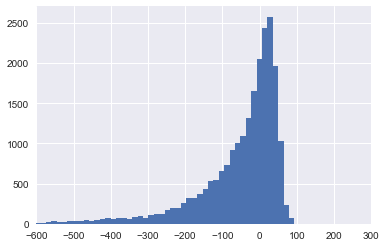

In [37]:
x = plt.hist(test.diff_ratio, bins = 1000)
plt.xlim(-600, 300)

In [38]:
mean_squared_error(test.reach, test.test_reach)**.5

15112.49320846564

In [39]:
test.describe()

,followers,likes,comments,reach,test_reach,reach_diff,diff_ratio
count,22640.000000,22640.000000,22640.00000,22640.000000,22640.000000,22640.000000,22640.000000
mean,40467.839311,1165.169965,50.32447,9747.297703,9456.456665,290.841038,-58.268366
std,11459.267132,1223.536143,318.84899,17165.114768,9720.770396,15110.028026,160.484669
min,25002.000000,12.000000,1.00000,32.000000,1892.500000,-737208.000000,-14431.600000
25%,30555.500000,498.000000,12.00000,3555.000000,5463.550000,-3585.150000,-93.000000
50%,38119.000000,894.000000,29.00000,6334.000000,7952.550000,-947.200000,-16.500000
75%,49550.000000,1419.250000,58.00000,11068.500000,11146.750000,2093.800000,22.100000
max,64979.000000,31626.000000,34239.00000,899833.000000,786882.000000,733921.500000,93.700000


## Interactions.
Lets create a plot to see if the three variables are interacting with each other in the model. 

In [40]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df2["likes"].values.reshape(-1, 1)
comments = df2["comments"].values.reshape(-1, 1)
followers = df2["followers"].values.reshape(-1, 1)

regression_1.fit(likes, df2["reach"])
regression_2.fit(comments, df2["reach"])
regression_3.fit(followers, df2["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[5.68464179]
[81.06368097]
[0.17753606]


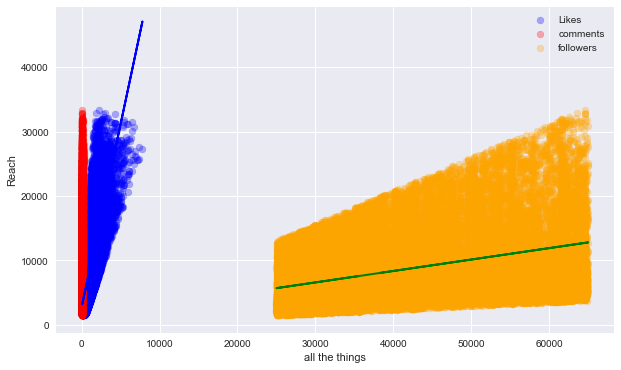

In [41]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df2["reach"],  color='blue', alpha = 0.3, label = "Likes")
plt.scatter(comments, df2["reach"],  color='red', alpha = 0.3, label = "comments")
plt.scatter(followers, df2["reach"],  color='orange', alpha = 0.3, label = "followers")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='green', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("all the things")
plt.legend();

## Summary of Users with 25k to 65k followers

We ran a test with to see the RMSE of our model using our training data. The RMSE was 3288.9, which is higher than our RMSE for the previous 3 bins of data (1k to 5k and 5k to 12.5k and 12.5k to 25k). When we use our test data with the model, we got a RMSE of over 17K. So our model is getting less predictive as we move into bins with higher follower counts.